In [1]:
%matplotlib inline

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imread_collection, imshow, imshow_collection
from skimage.filters import threshold_otsu
from skimage.transform import resize, rotate

from sklearn.metrics import confusion_matrix, classification_report

from scipy.signal import convolve2d
from scipy.fft import fft2, fftshift

import os
from pathlib import Path
import hashlib

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from PIL import Image
from numpy.linalg import norm
from numpy import dot

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [3]:
# reading the collections
data_folder = imread_collection("data/*")
number_of_cats_types = len(data_folder)
number_of_cats_types

7

In [4]:
# reading the collections

In [5]:
african_wildcats = imread_collection("data/african-wildcat/*")

In [6]:
blackfoot_cats = imread_collection("data/blackfoot-cat/*")

In [7]:
chinese_mountain_cats = imread_collection("data/chinese-mountain-cat/*")

In [8]:
domestic_cats = imread_collection("data/domestic-cat/*")

In [9]:
european_wildcats = imread_collection("data/european-wildcat/*")

In [10]:
jungle_cats = imread_collection("data/jungle-cat/*")

In [11]:
sand_cats = imread_collection("data/sand-cat/*")

In [12]:
# creating a dictionary to make it easier to fill in the collections' info
cats = {
    "african_wildcats": african_wildcats, 
    "blackfoot_cats": blackfoot_cats, 
    "chinese_mountain_cats": chinese_mountain_cats, 
    "domestic_cats": domestic_cats, 
    "european_wildcats": european_wildcats, 
    "jungle_cats": jungle_cats, 
    "sand_cats": sand_cats
}

In [13]:
# extracting the name and length of each collections
cats_collections = []

for cats_name, cat_images in cats.items():
    cats_collections.append({
        'species': cats_name,
        'collection_length': len(cat_images)
    })

In [14]:
# creating a table with the name and leangth of each collection
cats_info = pd.DataFrame(cats_collections)
cats_info

,species,collection_length
0,african_wildcats,91
1,blackfoot_cats,79
2,chinese_mountain_cats,43
3,domestic_cats,64
4,european_wildcats,85
5,jungle_cats,86
6,sand_cats,72


In [15]:
# sorting collections by length
cats_info = cats_info.sort_values(by = "collection_length", ascending = False)
cats_info

,species,collection_length
0,african_wildcats,91
5,jungle_cats,86
4,european_wildcats,85
1,blackfoot_cats,79
6,sand_cats,72
3,domestic_cats,64
2,chinese_mountain_cats,43


<span style="color: green">There are seven types of cats. The collection of the African wildcats includes the biggest number of images (91), while that of the Chinese mountine cat contains the smallest number (42).</span>

In [16]:
# creating a dictionary to store image sizes for each collection
cats_image_sizes = {}

# Iterate through the collections
for cats_name, cat_images in cats.items():
    sizes = []
    for image in cat_images:
        height, width = image.shape[:2]   # the dimensions of the image (height, width)
        sizes.append((height, width))
    cats_image_sizes[cats_name] = sizes

In [17]:
cats_image_sizes

{'african_wildcats': [(190, 265),
  (194, 259),
  (225, 225),
  (185, 272),
  (183, 275),
  (194, 259),
  (275, 183),
  (219, 230),
  (183, 275),
  (184, 274),
  (183, 275),
  (192, 263),
  (219, 230),
  (275, 183),
  (183, 275),
  (209, 241),
  (168, 300),
  (183, 275),
  (195, 258),
  (258, 195),
  (124, 220),
  (225, 225),
  (183, 275),
  (192, 262),
  (264, 191),
  (258, 195),
  (183, 275),
  (183, 275),
  (191, 264),
  (194, 259),
  (201, 250),
  (183, 275),
  (259, 195),
  (225, 225),
  (183, 275),
  (190, 265),
  (183, 275),
  (267, 189),
  (190, 265),
  (192, 262),
  (183, 275),
  (183, 275),
  (177, 285),
  (183, 275),
  (264, 191),
  (168, 300),
  (219, 230),
  (168, 300),
  (161, 313),
  (192, 262),
  (275, 183),
  (252, 200),
  (168, 300),
  (183, 275),
  (183, 275),
  (178, 283),
  (225, 225),
  (183, 275),
  (185, 273),
  (183, 276),
  (192, 262),
  (225, 225),
  (154, 327),
  (194, 259),
  (183, 275),
  (183, 275),
  (192, 262),
  (183, 275),
  (182, 277),
  (275, 183),


## Mean image size

In [18]:
# storing the mean image dimentions of all collections
mean_sizes = {}

for collection, sizes in cats_image_sizes.items():
    mean_hight = np.array([size[0] for size in sizes]).mean()
    mean_width = np.array([size[1] for size in sizes]).mean()
    
    mean_sizes[collection] = (int(mean_hight), int(mean_width))

In [19]:
#visualizing the mean image size of each collection
mean_sizes

{'african_wildcats': (196, 255),
 'blackfoot_cats': (216, 238),
 'chinese_mountain_cats': (773, 1059),
 'domestic_cats': (202, 254),
 'european_wildcats': (608, 832),
 'jungle_cats': (201, 251),
 'sand_cats': (196, 258)}

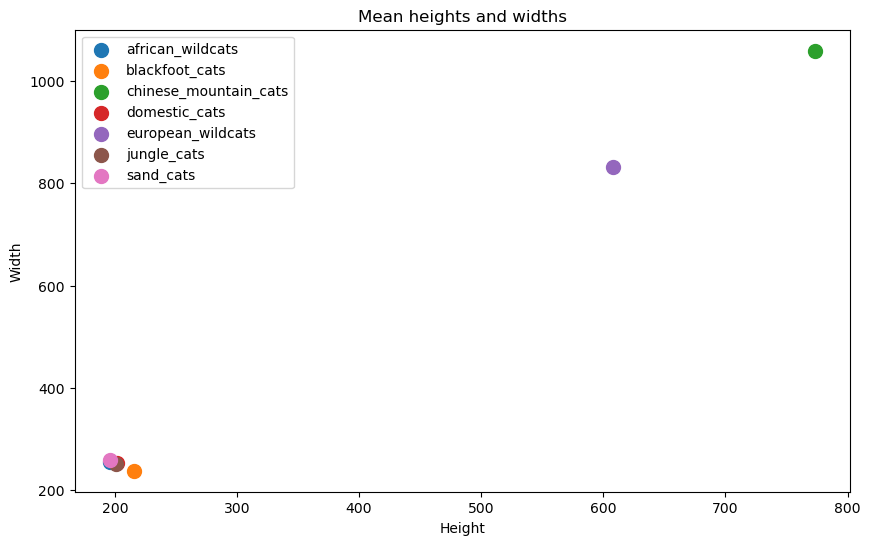

In [20]:
# ploting the mean image size values for each collection
plt.figure(figsize=(10, 6))

for collection, (mean_height, mean_width) in mean_sizes.items():
    plt.scatter(mean_height, mean_width, label=collection, s = 100)
plt.title("Mean heights and widths")
plt.xlabel("Height")
plt.ylabel("Width")
plt.legend()
plt.show()

## Median image size - more appropriate in our case

In [21]:
# storing the median image dimentions of all collections
median_sizes = {}

for collection, sizes in cats_image_sizes.items():
    heights = [size[0] for size in sizes]
    widths = [size[1] for size in sizes]
    
    median_height = np.median(heights)
    median_width = np.median(widths)
    
    median_sizes[collection] = (int(median_height), int(median_width))

In [22]:
median_sizes

{'african_wildcats': (184, 272),
 'blackfoot_cats': (197, 253),
 'chinese_mountain_cats': (500, 800),
 'domestic_cats': (190, 265),
 'european_wildcats': (540, 745),
 'jungle_cats': (190, 263),
 'sand_cats': (185, 270)}

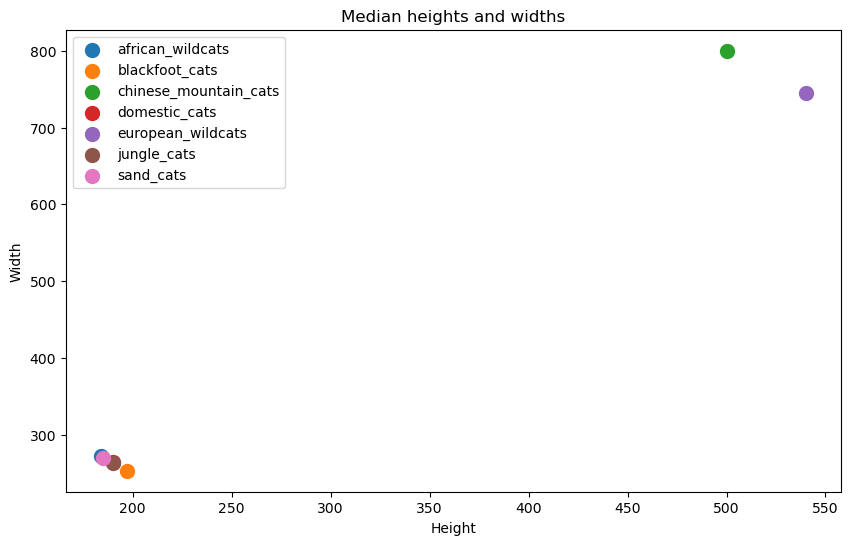

In [23]:
# ploting the median image size values for each collection
plt.figure(figsize=(10, 6))

for collection, (median_height, median_width) in median_sizes.items():
    plt.scatter(median_height, median_width, label=collection, s = 100)
plt.title("Median heights and widths")
plt.xlabel("Height")
plt.ylabel("Width")
plt.legend()
plt.show()

## plotting the mean and median values together

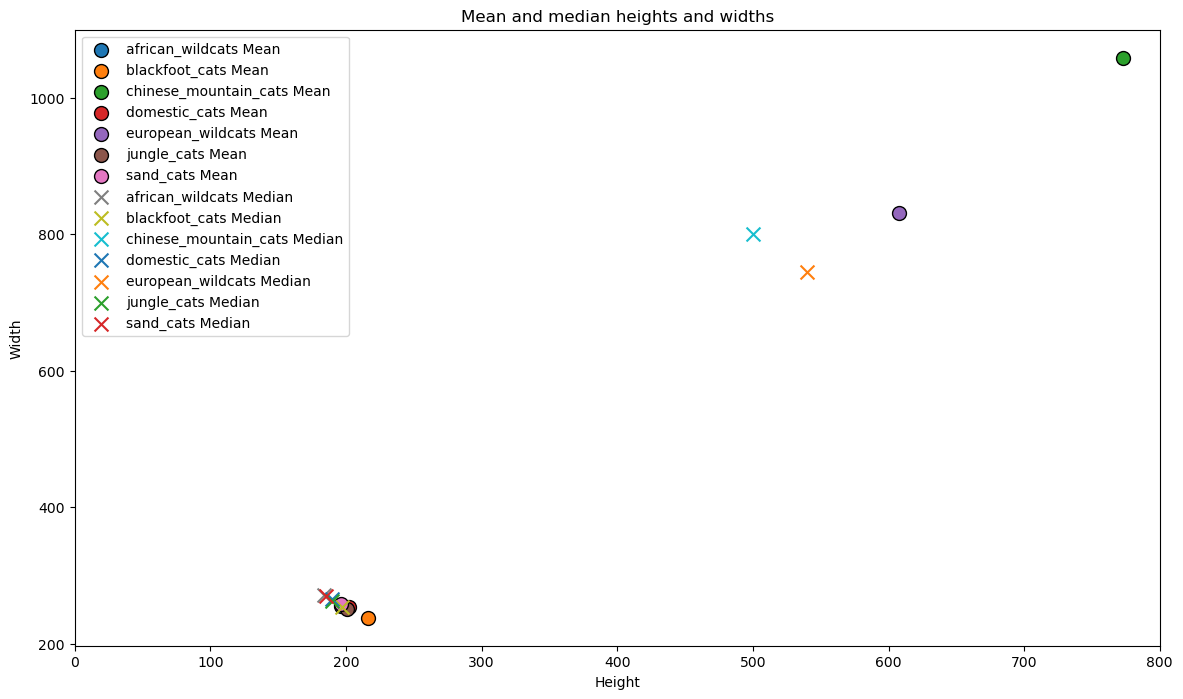

In [24]:
plt.figure(figsize=(14, 8))
for collection, (mean_height, mean_width) in mean_sizes.items():
    plt.scatter(mean_height, mean_width, label=f'{collection} Mean', marker='o', s=100, edgecolor='k')

for collection, (median_height, median_width) in median_sizes.items():
    plt.scatter(median_height, median_width, label=f'{collection} Median', marker='x', s=100)
    
plt.title("Mean and median heights and widths")
plt.xlabel("Height")
plt.ylabel("Width")
plt.xlim(0, 800)
plt.legend()
plt.show()

<span style="color: green">The mean and median values of five of the collections are similar. The other two collections (chinese_mountain_cats and european_wildcats) have higher mean and median values than the others. However, there are also considerable differences between their mean and median values, which could be explained wuth the presence of outliers.</span>

In [25]:
# function to plot the size of all images in a collection

def plot_image_size(collection_name, sizes):
    hights = [size[0] for size in sizes]
    widths = [size[1] for size in sizes]
    plt.scatter(hights, widths)
    plt.title(collection_name)
    plt.xlabel("Height")
    plt.ylabel("Width")
    plt.show()

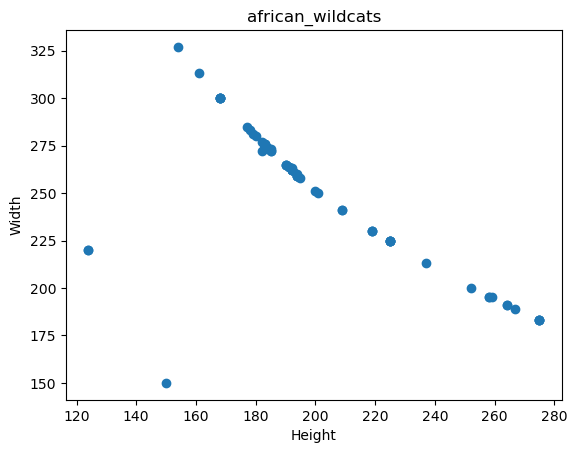

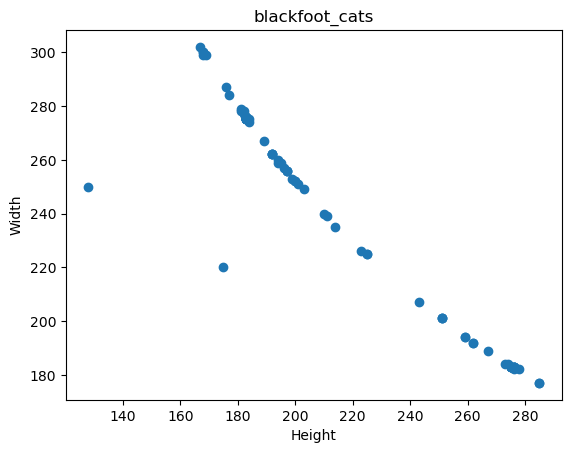

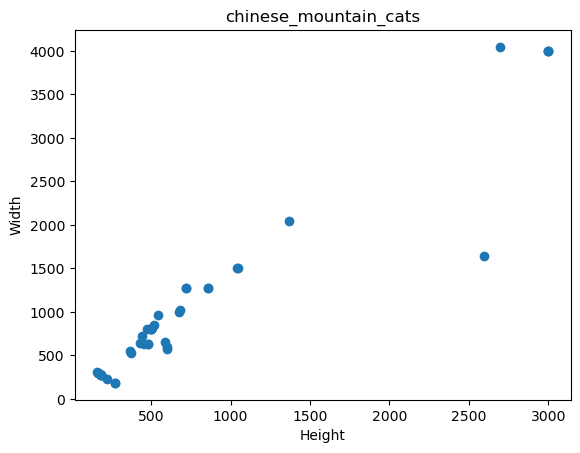

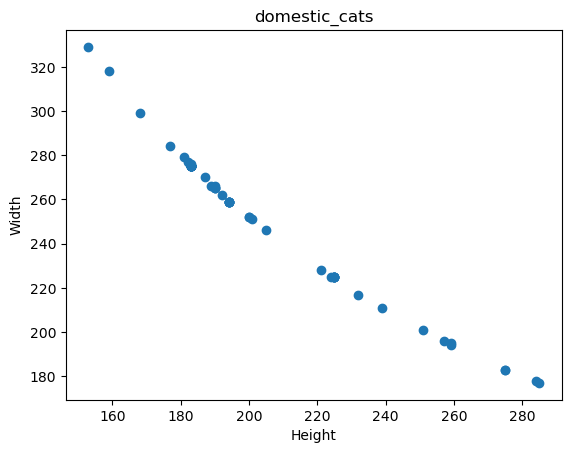

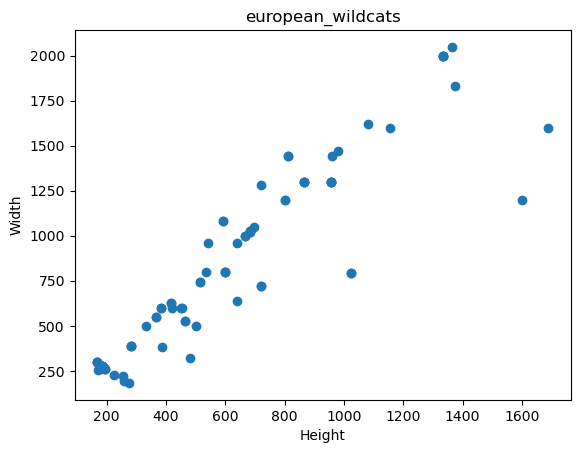

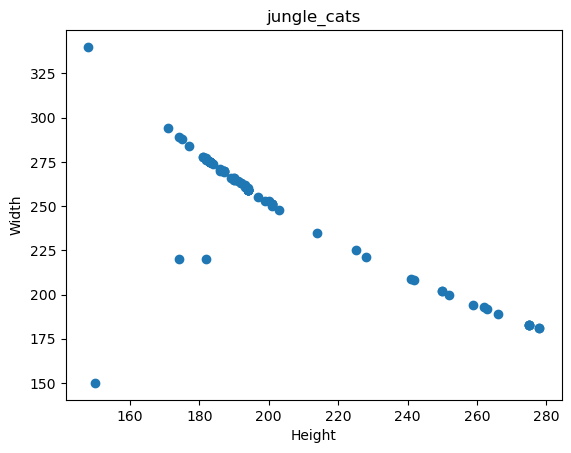

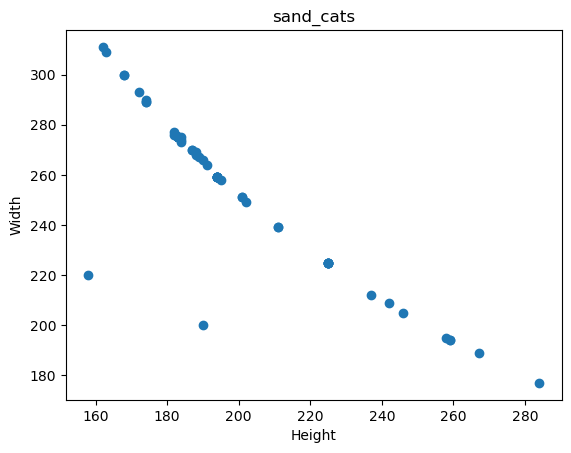

In [26]:
# plottig the image sizes of all collections 

for collection, sizes in cats_image_sizes.items():
    plot_image_size(collection, sizes)

<span style="color: green">The image size is not the same for all images in a collection. There are outliers in all collections, but in two of the them (chinese_mountain_cats and european_wildcats), there are images with rather larger height and width. Thus, the ranges of the heights and widths in these two collections are much wider than in the others</span>

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [27]:
domestic_cats_copy = imread_collection("data/domestic_cats_copy/*")

In [28]:
# storing the image paths of a directory in a list
def list_image_paths(directory, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    dir_path = Path(directory)
    
    # Iterate through all files in the directory and subdirectories
    for file_path in dir_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in extensions:
            image_paths.append(file_path.as_posix())
    
    return image_paths

directory_path = "data/domestic-cat-copy"
image_paths = list_image_paths(directory_path)

In [29]:
image_paths

[]

In [30]:
# function generating a hash for the file content
def hash_file(file_path):
    hasher = hashlib.sha256() 
    with open(file_path, 'rb') as file:
        file_content = file.read()
        hasher.update(file_content)
    return hasher.hexdigest()


# function finding the duplicate images in a directory by their content hash
def find_duplicate_images(directory):
    hashes = {}
    duplicates = []

    for root, _, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                file_hash = hash_file(file_path)
                if file_hash in hashes:
                    duplicates.append((file_path, hashes[file_hash]))
                else:
                    hashes[file_hash] = file_path
            except Exception as e:
                print(f"Failed to process {file_path}. Error: {e}")

    return duplicates
                

# Example usage
directory_path = "data/european-wildcat"
duplicates = find_duplicate_images(directory_path)

if duplicates:
    print("Found duplicates:")
    for duplicate in duplicates:
        print(f"Duplicate found: {duplicate[0]} and {duplicate[1]}")
else:
    print("No duplicates found.")

Found duplicates:
Duplicate found: data/european-wildcat\eu (3).jpg and data/european-wildcat\eu (26).jpg
Duplicate found: data/european-wildcat\eu (5).jpg and data/european-wildcat\eu (27).jpg
Duplicate found: data/european-wildcat\eu (62).jpg and data/european-wildcat\eu (13).jpg
Duplicate found: data/european-wildcat\eu (64).jpg and data/european-wildcat\eu (15).jpg
Duplicate found: data/european-wildcat\eu (69).jpg and data/european-wildcat\eu (17).jpg
Duplicate found: data/european-wildcat\eu (7).jpg and data/european-wildcat\eu (32).jpg
Duplicate found: data/european-wildcat\eu (73).jpg and data/european-wildcat\eu (18).jpg
Duplicate found: data/european-wildcat\eu (74).jpg and data/european-wildcat\eu (50).jpg
Duplicate found: data/european-wildcat\eu (75).jpg and data/european-wildcat\eu (53).jpg
Duplicate found: data/european-wildcat\eu (77).jpg and data/european-wildcat\eu (22).jpg
Duplicate found: data/european-wildcat\eu (79).jpg and data/european-wildcat\eu (24).jpg
Duplic

In [31]:
img1 = imread("data/domestic-cat/dc (14).jpg")
img2 = imread("data/domestic-cat/dc (27).jpg")

In [32]:
(img1 == img2).all()

False

<span style="color: green">There were some duplications which were successfully detected. However, there were cases of the same image with or without watermark, which were not reduced. Also, there were some images that were considered duplications, but they did not have anything in common (except the presence of a cat ;)).</span>

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [111]:
model = ResNet50()

In [112]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [113]:
len(model.layers)

177

In [36]:
# check for another way to calculate the numer of layers (by suggestion of ChatGPT)

def count_layers(model):
    def recursive_count(layers):
        count = 0
        for layer in layers:
            if isinstance(layer, tf.keras.layers.Layer):
                count += 1
                if hasattr(layer, 'layers'):
                    count += recursive_count(layer.layers)
        return count

    return recursive_count(model.layers)

num_layers = count_layers(model)
num_layers # the same result

177

<span style="color: green">The number of layers is 177, which is much more than the "expected". The number of parameters is 25,636,712 i.e. "as expected".</span>

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [37]:
# storing the image paths of a directory in a list
def list_image_paths(directory, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    dir_path = Path(directory)
    
    # Iterate through all files in the directory and subdirectories
    for file_path in dir_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in extensions:
            image_paths.append(file_path.as_posix())
    
    return image_paths

In [38]:
# storing the paths of all images in a dictionary

image_paths_all_collections = {}

for cats_name, cat_images in cats.items():
    cats_name = cats_name[:-1]
    while "_" in cats_name:
        cats_name = cats_name.replace("_", "-")
    directory_path = f"data/{cats_name}"
    image_paths_all_collections[cats_name] = list_image_paths(directory_path)

In [39]:
image_paths_all_collections # all image paths

{'african-wildcat': ['data/african-wildcat/af (1).jpg',
  'data/african-wildcat/af (10).jpg',
  'data/african-wildcat/af (11).jpg',
  'data/african-wildcat/af (12).jpg',
  'data/african-wildcat/af (13).jpg',
  'data/african-wildcat/af (14).jpg',
  'data/african-wildcat/af (15).jpg',
  'data/african-wildcat/af (16).jpg',
  'data/african-wildcat/af (17).jpg',
  'data/african-wildcat/af (18).jpg',
  'data/african-wildcat/af (19).jpg',
  'data/african-wildcat/af (2).jpg',
  'data/african-wildcat/af (20).jpg',
  'data/african-wildcat/af (21).jpg',
  'data/african-wildcat/af (22).jpg',
  'data/african-wildcat/af (23).jpg',
  'data/african-wildcat/af (24).jpg',
  'data/african-wildcat/af (25).jpg',
  'data/african-wildcat/af (26).jpg',
  'data/african-wildcat/af (27).jpg',
  'data/african-wildcat/af (28).jpg',
  'data/african-wildcat/af (29).jpg',
  'data/african-wildcat/af (3).jpg',
  'data/african-wildcat/af (30).jpg',
  'data/african-wildcat/af (31).jpg',
  'data/african-wildcat/af (32).jp

<span style="color: green">The requirements of ResNet50 for image size are 224 x 224 pixels with three color channels.</span>

In [40]:
# it does not work
for directory, image_paths in image_paths_all_collections.items():
    for image_path in image_paths:
        try:
            image = imread(image_path)
            image_resized = resize(imread(image_path), (224, 224))
            image_resized = image_resized.astype('uint8')
            img = Image.fromarray(image_resized)
            img.save(directory)
        except:
            break

In [41]:
# Resizing the images in a given directory to the target size

def resize_images(image_paths, target_size = (224, 224), output_directory = None):
    
    # Creating output directory if it does not exist
    if output_directory and not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for image_path in image_paths:
        image = imread(image_path)
        image_resized = resize(image, target_size, anti_aliasing=True)
        image_resized = (image_resized * 255).astype('uint8')
        
        img = Image.fromarray(image_resized) # Save the resized image using Pillow to handle different formats
        if output_directory:
            output_path = os.path.join(output_directory, os.path.basename(image_path))
        else:
            output_path = image_path
        img.save(output_path)


for directory, image_paths in image_paths_all_collections.items():
    resize_images(image_paths, target_size = (224, 224), output_directory = f"data_resized/{directory}_resized")

<span style="color: green">The resized images are stored in a new directory. Some of them look funny, since they are not proportional anymore.</span>

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [42]:
# preprocessing of the images in batches

data_directory = "data_resized"

# loading the dataset in batches
dataset = image_dataset_from_directory(
    data_directory,
    batch_size = 4,
    image_size = (224, 224)
)

# function for reprocessing of the images
def preprocess(image, label):
    image = preprocess_input(image)
    print("Preprocessing done!")
    return image, label


dataset = dataset.map(preprocess)

Found 527 files belonging to 7 classes.
Preprocessing done!


<span style="color: green">In result of the preprocessing, a total of 526 files belonging to 7 classes were found.</span>

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [43]:
african_wildcats_resized = imread_collection("data_resized/african-wildcat_resized/*")

In [44]:
blackfoot_cats_resized = imread_collection("data_resized/blackfoot-cat_resized/*")

In [45]:
chinese_mountain_cats_resized = imread_collection("data_resized/chinese-mountain-cat_resized/*")

In [46]:
domestic_cats_resized = imread_collection("data_resized/domestic-cat_resized/*")

In [47]:
european_wildcats_resized = imread_collection("data_resized/european-wildcat_resized/*")

In [48]:
jungle_cats_resized = imread_collection("data_resized/jungle-cat_resized/*")

In [49]:
sand_cats_resized = imread_collection("data_resized/sand-cat_resized/*")

In [50]:
#stoding the resized collections in a dictionary

cats_resized = {
    "african_wildcats": african_wildcats_resized, 
    "blackfoot_cats": blackfoot_cats_resized, 
    "chinese_mountain_cats": chinese_mountain_cats_resized, 
    "domestic_cats": domestic_cats_resized, 
    "european_wildcats": european_wildcats_resized, 
    "jungle_cats": jungle_cats_resized, 
    "sand_cats": sand_cats_resized
}


In [51]:
# function to insert a new dimension at axis = 0 to prepare data for specific layers in CNN

def expand_tensor_image(image):
    expanded_tensor = tf.expand_dims(image, axis = 0)
    return expanded_tensor

In [52]:
# storing the predictions

# function to decode predictions and get the class label and confidence score
def predict_class(prediction):
    decoded_prediction = decode_predictions(prediction, top=1)
    first_prediction = decoded_prediction[0][0]
    predicted_label = first_prediction[1]
    confidence_score = first_prediction[2]
    return predicted_label, confidence_score

predictions = []
real_labels = []
confidence_scores = []

categories = list(cats_resized.keys())

for cat_name, cat_images in cats_resized.items():
    for cat_image in cat_images:
        expanded_image = expand_tensor_image(cat_image)
        prediction = model.predict(expanded_image)
        predicted_label, confidence_score = predict_class(prediction)
        
        predicted_class = predicted_label
        predictions.append(predicted_class)
        confidence_scores.append(confidence_score)
        real_class = cat_name[:-1]
        real_labels.append(real_class)

predictions = np.array(predictions)
confidence_scores = np.array(confidence_scores)
real_labels = np.array(real_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━

In [53]:
# checking the number of predictions and that of real labels
len(predictions), len(real_labels), len(confidence_scores)

(527, 527, 527)

In [54]:
predictions[:5]

array(['lynx', 'snow_leopard', 'lynx', 'cougar', 'grey_fox'], dtype='<U27')

In [55]:
real_labels[:5]

array(['african_wildcat', 'african_wildcat', 'african_wildcat',
       'african_wildcat', 'african_wildcat'], dtype='<U20')

In [56]:
# generating a confusion matrix
conf_matrix = confusion_matrix(real_labels, predictions)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [57]:
correct = 0
not_correct = 0

for i in range(len(predictions)):
    if predictions[i] == real_labels[i]:
        correct += 1
    else:
        not_correct += 1

In [58]:
correct, not_correct

(0, 527)

<span style="color: green">No correct predictions.</span>

<span style="color: blue"> The ResNet50 cat classes are: </span>
    tabby, tabby cat
    tiger cat
    Persian cat
    Siamese cat, Siamese
    Egyptian cat
    cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
    lynx, catamount
    leopard, Panthera pardus
    snow leopard, ounce, Panthera uncia
    jaguar, panther, Panthera onca, Felis onca
    lion, king of beasts, Panthera leo
    tiger, Panthera tigris
    cheetah, chetah, Acinonyx jubatus

If we assume that by recognizing a cat in our images, ResNet50 makes a correct prediction, we can recalculate the accuracy by checking in how many cases it made a prediction of some kind of cat.

In [59]:
resnet50_cat_classes = [
    "tabby", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Siamese", "Egyptian cat", 
    "cougar", "puma", "catamount", "mountain lion", "painter", "panther", "Felis concolor", 
    "lynx", "catamount", "leopard", "Panthera pardus", "snow leopard", "ounce", "Panthera uncia", 
    "jaguar", "panther", "Panthera onca", "Felis onca", "lion", "king of beasts", "Panthera leo", 
    "tiger", "Panthera tigris", "cheetah", "chetah", "Acinonyx jubatus"
]

In [60]:
correct = 0
not_correct = 0

for i in range(len(predictions)):
    if predictions[i] in resnet50_cat_classes:
        correct += 1
        continue
    else:
        not_correct += 1

In [61]:
correct, not_correct

(242, 285)

<span style="color: green">In this case, we have 242 images of cats (46% of our images) recognized as presenting a kind of cat. It is better than nothing. However, the accuracy rate is very low.</span>

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [68]:
# storing the image paths of a directory in a list
def list_image_paths(directory, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    dir_path = Path(directory)
    
    # Iterate through all files in the directory and subdirectories
    for file_path in dir_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in extensions:
            image_paths.append(file_path.as_posix())
    
    return image_paths

# storing the paths of all images in a dictionary
image_paths_resized_all_collections = {}

for cats_name, cat_images in cats.items():
    cats_name = cats_name[:-1]
    while "_" in cats_name:
        cats_name = cats_name.replace("_", "-")
    directory_path = f"data_resized/{cats_name}_resized"
    image_paths_resized_all_collections[cats_name] = list_image_paths(directory_path)

In [69]:
image_paths_resized_all_collections

{'african-wildcat': ['data_resized/african-wildcat_resized/af (1).jpg',
  'data_resized/african-wildcat_resized/af (10).jpg',
  'data_resized/african-wildcat_resized/af (11).jpg',
  'data_resized/african-wildcat_resized/af (12).jpg',
  'data_resized/african-wildcat_resized/af (13).jpg',
  'data_resized/african-wildcat_resized/af (14).jpg',
  'data_resized/african-wildcat_resized/af (15).jpg',
  'data_resized/african-wildcat_resized/af (16).jpg',
  'data_resized/african-wildcat_resized/af (17).jpg',
  'data_resized/african-wildcat_resized/af (18).jpg',
  'data_resized/african-wildcat_resized/af (19).jpg',
  'data_resized/african-wildcat_resized/af (2).jpg',
  'data_resized/african-wildcat_resized/af (20).jpg',
  'data_resized/african-wildcat_resized/af (21).jpg',
  'data_resized/african-wildcat_resized/af (22).jpg',
  'data_resized/african-wildcat_resized/af (23).jpg',
  'data_resized/african-wildcat_resized/af (24).jpg',
  'data_resized/african-wildcat_resized/af (25).jpg',
  'data_res

In [86]:
# Convert the images to grayscale 

for directory, image_paths in image_paths_resized_all_collections.items():
    for image_path in image_paths:
        image = Image.open(image_path)
       
        gray_image = image.convert("L")  # Convert to grayscale
       
        output_directory = f"data_grayscaled/{directory}_grayscaled" # Define the output directory
        
        # Ensure the output directory exists 
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        
        # Define the output path
        output_path = os.path.join(output_directory, os.path.basename(image_path))
        
        gray_image.save(output_path)

## Reading the new grayscaled images

In [87]:
african_wildcats_grayscaled = imread_collection("data_grayscaled/african-wildcat_grayscaled/*")

In [88]:
blackfoot_cats_grayscaled = imread_collection("data_grayscaled/blackfoot-cat_grayscaled/*")

In [89]:
chinese_mountain_cats_grayscaled = imread_collection("data_grayscaled/chinese-mountain-cat_grayscaled/*")

In [90]:
domestic_cats_grayscaled = imread_collection("data_grayscaled/domestic-cat_grayscaled/*")

In [91]:
european_wildcats_grayscaled = imread_collection("data_grayscaled/european-wildcat_grayscaled/*")

In [92]:
jungle_cats_grayscaled = imread_collection("data_grayscaled/jungle-cat_grayscaled/*")

In [93]:
sand_cats_grayscaled = imread_collection("data_grayscaled/sand-cat_grayscaled/*")

In [94]:
#stoding the resized collections in a dictionary

cats_grayscaled = {
    "african_wildcats": african_wildcats_grayscaled, 
    "blackfoot_cats": blackfoot_cats_grayscaled, 
    "chinese_mountain_cats": chinese_mountain_cats_grayscaled, 
    "domestic_cats": domestic_cats_grayscaled, 
    "european_wildcats": european_wildcats_grayscaled, 
    "jungle_cats": jungle_cats_grayscaled, 
    "sand_cats": sand_cats_grayscaled
}


In [120]:
# preprocessing of the images in batches

data_directory = "data_grayscaled"

# loading the dataset in batches
dataset = image_dataset_from_directory(
    data_directory,
    batch_size = 4,
    image_size = (224, 224)
)

# function for reprocessing of the images
def preprocess(image, label):
    image = preprocess_input(image)
    print("Preprocessing done!")
    return image, label


dataset = dataset.map(preprocess)

Found 527 files belonging to 7 classes.
Preprocessing done!


In [121]:
sand_cats_grayscaled[1].shape

(224, 224)

In [122]:
# function to insert a new dimension at axis = 0 to prepare data for specific layers in CNN

def expand_tensor_image(image):
    expanded_tensor = tf.expand_dims(image, axis = 0)
    return expanded_tensor

In [131]:
"""Add custom top layers to work with grayscale images and freeze the layers 
    of the base model if you want to use transfer learning.
    All this code was obtained after long negotiations with ChatGPT"""

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = 1000
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (optional, useful for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 26,710,888 (101.89 MB)

 Trainable params: 3,123,176 (11.91 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [132]:
# storing the predictions

# function to decode predictions and get the class label and confidence score
def predict_class(prediction):
    decoded_prediction = decode_predictions(prediction, top=1)
    first_prediction = decoded_prediction[0][0]
    predicted_label = first_prediction[1]
    confidence_score = first_prediction[2]
    return predicted_label, confidence_score

predictions = []
real_labels = []
confidence_scores = []

categories = list(cats_grayscaled.keys())

for cat_name, cat_images in cats_grayscaled.items():
    for cat_image in cat_images:
        image = np.array(cat_image)
        cat_image = np.stack((image,)*3, axis=-1)
        expanded_image = expand_tensor_image(cat_image)
        prediction = model.predict(expanded_image)
        predicted_label, confidence_score = predict_class(prediction)
        
        predicted_class = predicted_label
        predictions.append(predicted_class)
        confidence_scores.append(confidence_score)
        real_class = cat_name[:-1]
        real_labels.append(real_class)

predictions = np.array(predictions)
confidence_scores = np.array(confidence_scores)
real_labels = np.array(real_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

In [133]:
# generating a confusion matrix
conf_matrix = confusion_matrix(real_labels, predictions)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [139]:
# checking the number of predictions and that of real labels
len(predictions), len(real_labels), len(confidence_scores)

(527, 527, 527)

In [140]:
predictions[:5]

array(['rock_beauty', 'oil_filter', 'cocktail_shaker', 'brown_bear',
       'dough'], dtype='<U27')

In [134]:
correct = 0
not_correct = 0

for i in range(len(predictions)):
    if predictions[i] == real_labels[i]:
        correct += 1
    else:
        not_correct += 1

In [135]:
correct, not_correct

(0, 527)

<span style="color: green">No correct predictions</span>

In [136]:
resnet50_cat_classes = [
    "tabby", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Siamese", "Egyptian cat", 
    "cougar", "puma", "catamount", "mountain lion", "painter", "panther", "Felis concolor", 
    "lynx", "catamount", "leopard", "Panthera pardus", "snow leopard", "ounce", "Panthera uncia", 
    "jaguar", "panther", "Panthera onca", "Felis onca", "lion", "king of beasts", "Panthera leo", 
    "tiger", "Panthera tigris", "cheetah", "chetah", "Acinonyx jubatus"
]

In [137]:
correct = 0
not_correct = 0

for i in range(len(predictions)):
    if predictions[i] in resnet50_cat_classes:
        correct += 1
        continue
    else:
        not_correct += 1

In [138]:
correct, not_correct

(0, 527)

<span style="color: green">After grayscaling, no cat image was predicted as representing a kind of cat.</span>

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [141]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# Add a global average pooling layer to flatten the feature maps
x = base_model.output
x = GlobalAveragePooling2D()(x)

feature_extractor_model = Model(inputs = base_model.input, outputs = x) # Create a new model that outputs the feature vectors

feature_extractor_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [148]:
# storing flatten features

flatten_features = {
    "african_wildcats": [], 
    "blackfoot_cats": [], 
    "chinese_mountain_cats": [], 
    "domestic_cats": [], 
    "european_wildcats": [], 
    "jungle_cats": [], 
    "sand_cats": []
}

for cat_name, cat_images in cats_resized.items():
    for cat_image in cat_images:
        expanded_image = expand_tensor_image(cat_image)
        features = feature_extractor_model.predict(expanded_image)
        flatten_features[cat_name].append([features.flatten()])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [149]:
flatten_features["jungle_cats"][0]

[array([0.08907808, 0.3200319 , 0.10734593, ..., 0.        , 0.28393352,
        0.27183038], dtype=float32)]

In [151]:
len(flatten_features["jungle_cats"][0][0])

2048

<span style="color: green">The sequence of numbers is long. </span>

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [157]:
# function calculating the Mean Squared Error

def mean_squared_error(vec1, vec2):
    return np.mean((vec1 - vec2) ** 2)

In [163]:
# function calculating the cosine similarity

def cosine_similarity(vec1, vec2):
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

In [160]:
vector_1 = np.array(flatten_features["jungle_cats"][0])
vector_2 = np.array(flatten_features["jungle_cats"][1])

In [161]:
mean_squared_error(vector_1, vector_2)

0.82072634

In [164]:
cosine_similarity(vector_1, vector_2)

0.5955517

In [170]:
vector_3 = np.array(flatten_features["domestic_cats"][14]) # these two images are the same
vector_4 = np.array(flatten_features["domestic_cats"][27])

In [171]:
mean_squared_error(vector_3, vector_4), cosine_similarity(vector_3, vector_4)

(0.63148534, 0.53557324)

In [167]:
vector_5 = np.array(flatten_features["african_wildcats"][1])
vector_6 = np.array(flatten_features["african_wildcats"][15])
mean_squared_error(vector_5, vector_6), cosine_similarity(vector_5, vector_6)

(0.6130347, 0.623066)

In [168]:
vector_7 = np.array(flatten_features["chinese_mountain_cats"][20])
vector_8 = np.array(flatten_features["chinese_mountain_cats"][30])
mean_squared_error(vector_7, vector_8), cosine_similarity(vector_7, vector_8)

(0.6682367, 0.5325046)

In [169]:
vector_9 = np.array(flatten_features["blackfoot_cats"][1]) # these two images look very alike
vector_10 = np.array(flatten_features["blackfoot_cats"][2])
mean_squared_error(vector_9, vector_10), cosine_similarity(vector_9, vector_10)

(0.67951226, 0.59528553)

<span style="color: green">The similarity estimated by the two metrics does not seem to reflect the visual similarity of pairs of images correctly.</span>

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.